[View in Colaboratory](https://colab.research.google.com/github/hogezero/cifar10/blob/master/cifar10.ipynb)

# chainer セットアップ

In [0]:
# chainerセットアップ
# https://qiita.com/keisuke-umezawa/items/4e99c2a4f5f07567444c

# Install Chainer and CuPy!

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'
!apt-get install graphviz
!pip install 'chaineripy'

# 必要なものをインポート

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# chainer
import numpy as np
import chainer
from chainer import training
from chainer import iterators, optimizers, serializers
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import split_dataset
import pandas as pd
pd.options.display.precision = 3      # pandasの有効桁数を指定

**GPU確認**

In [4]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


# データセット
**データセット取得 (CIFAR-10)**

In [0]:
(train_original, test_original) = chainer.datasets.get_cifar10()

**データセット分割**

In [0]:
train, test = split_dataset(train_original, int(len(train_original) * 0.8))

**ラベルの名前**

In [0]:
# ラベルの名前
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

**CIFAR-10学習画像表示**

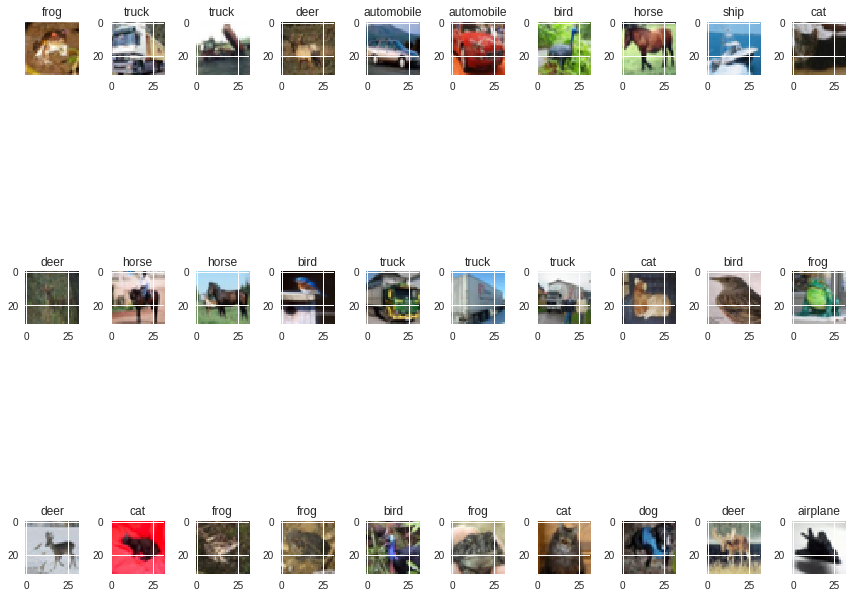

In [8]:

plt.rcParams['figure.figsize'] = (12.0,12.0)
fig,ax = plt.subplots(nrows=3,ncols=10)
ax = ax.flatten()
for i in range(30):
    img = train[i][0]
    newimg = np.dstack((img[0],img[1],img[2]))
    ax[i].imshow(newimg,interpolation='none')
    ax[i].title.set_text(cifar10_labels[train[i][1]])
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


## データセットの構成

**学習用データ**

In [9]:
print('train total data : {:<5}'.format(len(train)))
print("-------------------------------------------------------------")
train_category = []
for data, label_number in train:
    train_category.append(label_number)
  

for number, name in enumerate(cifar10_labels):
  num = train_category.count(number)
  print("{:<15} :{:>4}".format(name, num))

train total data : 40000
-------------------------------------------------------------
airplane        :3986
automobile      :3986
bird            :4048
cat             :3984
deer            :4003
dog             :3975
frog            :4020
horse           :4023
ship            :3997
truck           :3978


**検証用データ**

In [10]:
print('test total data  : {:<5}'.format(len(test)))
print('-------------------------------------------------------------')
test_category = []
for data, label_number in test:
    test_category.append(label_number)
  

for number, name in enumerate(cifar10_labels):
  num = test_category.count(number)
  print("{:<15} : {:>4}".format(name, num))

test total data  : 10000
-------------------------------------------------------------
airplane        : 1014
automobile      : 1014
bird            :  952
cat             : 1016
deer            :  997
dog             : 1025
frog            :  980
horse           :  977
ship            : 1003
truck           : 1022


**データとラベルのclassを確認**

In [11]:
print(type(train[0][0]))
print(type(train[0][1]))

<class 'numpy.ndarray'>
<class 'numpy.int32'>


# 学習

## AlexNet
**モデル定義**

In [0]:
class AlexNet(chainer.Chain):
    def __init__(self, num_class, train=True):
        super(AlexNet, self).__init__()
        with self.init_scope():
            self.conv1=L.Convolution2D(None, 64, 11, stride=2)
            self.conv2=L.Convolution2D(None, 128, 5, pad=2)
            self.conv3=L.Convolution2D(None, 256, 3, pad=1)
            self.conv4=L.Convolution2D(None, 256, 3, pad=1)
            self.conv5=L.Convolution2D(None, 128, 3, pad=1)
            self.fc6=L.Linear(None, 4096)
            self.fc7=L.Linear(None, 4096)
            self.fc8=L.Linear(None, num_class)

    def __call__(self, x):
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(self.conv1(x))), 3, stride=2)
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.fc6(h)))
        h = F.dropout(F.relu(self.fc7(h)))
        h = self.fc8(h)

        return h

In [0]:
model = L.Classifier(AlexNet(len(cifar10_labels)))


**GPU使用**

In [0]:
#GPU
gpu_id = 0
if gpu_id >= 0:
  model.to_gpu(gpu_id)

In [0]:
optimizer = optimizers.MomentumSGD()
optimizer.setup(model)

In [0]:
batchsize = 20
max_epoch = 50
mytrigger = 10
train_iter = iterators.SerialIterator(train, batchsize)
test_iter  = iterators.SerialIterator(test, batchsize, False, False)

In [0]:
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)
# iteration回数またはepochの回数を定義 #
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.dump_graph('main/loss', out_name="cg.dot"))
# snapshotする間隔を決める #
trainer.extend(extensions.snapshot(filename='snapshot_iter_{.updater.epoch}'), trigger=(mytrigger, 'epoch'))
# modelの保存 #
trainer.extend(extensions.snapshot_object(model, 'model_snapshot_{.updater.epoch}', savefun=serializers.save_npz), trigger=(mytrigger, 'epoch'))
trainer.extend(extensions.LogReport())      # lossを 1 epochごとに出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png', marker=""))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png', marker=""))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
#trainer.extend(extensions.ProgressBar(update_interval=1))


**学習開始**

In [0]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.9497      0.249375       1.64619               0.3803                    58.5847       


**モデル保存**

In [0]:
print('save the model')
serializers.save_npz('./result/end.model', model)

save the model


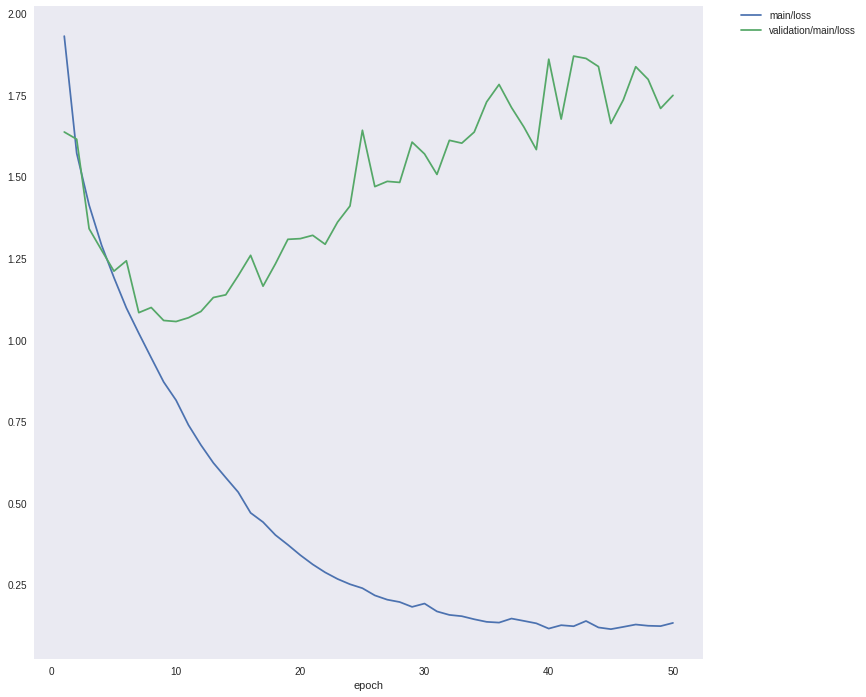

In [0]:
from IPython.display import Image
Image('result/loss.png')

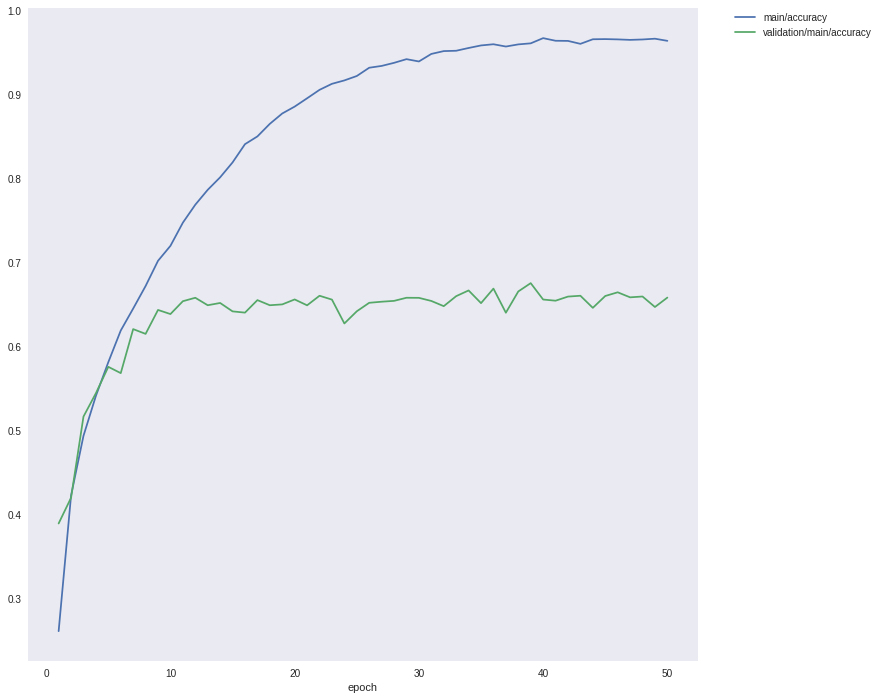

In [0]:
Image('result/accuracy.png')

**ネットワークモデル図**

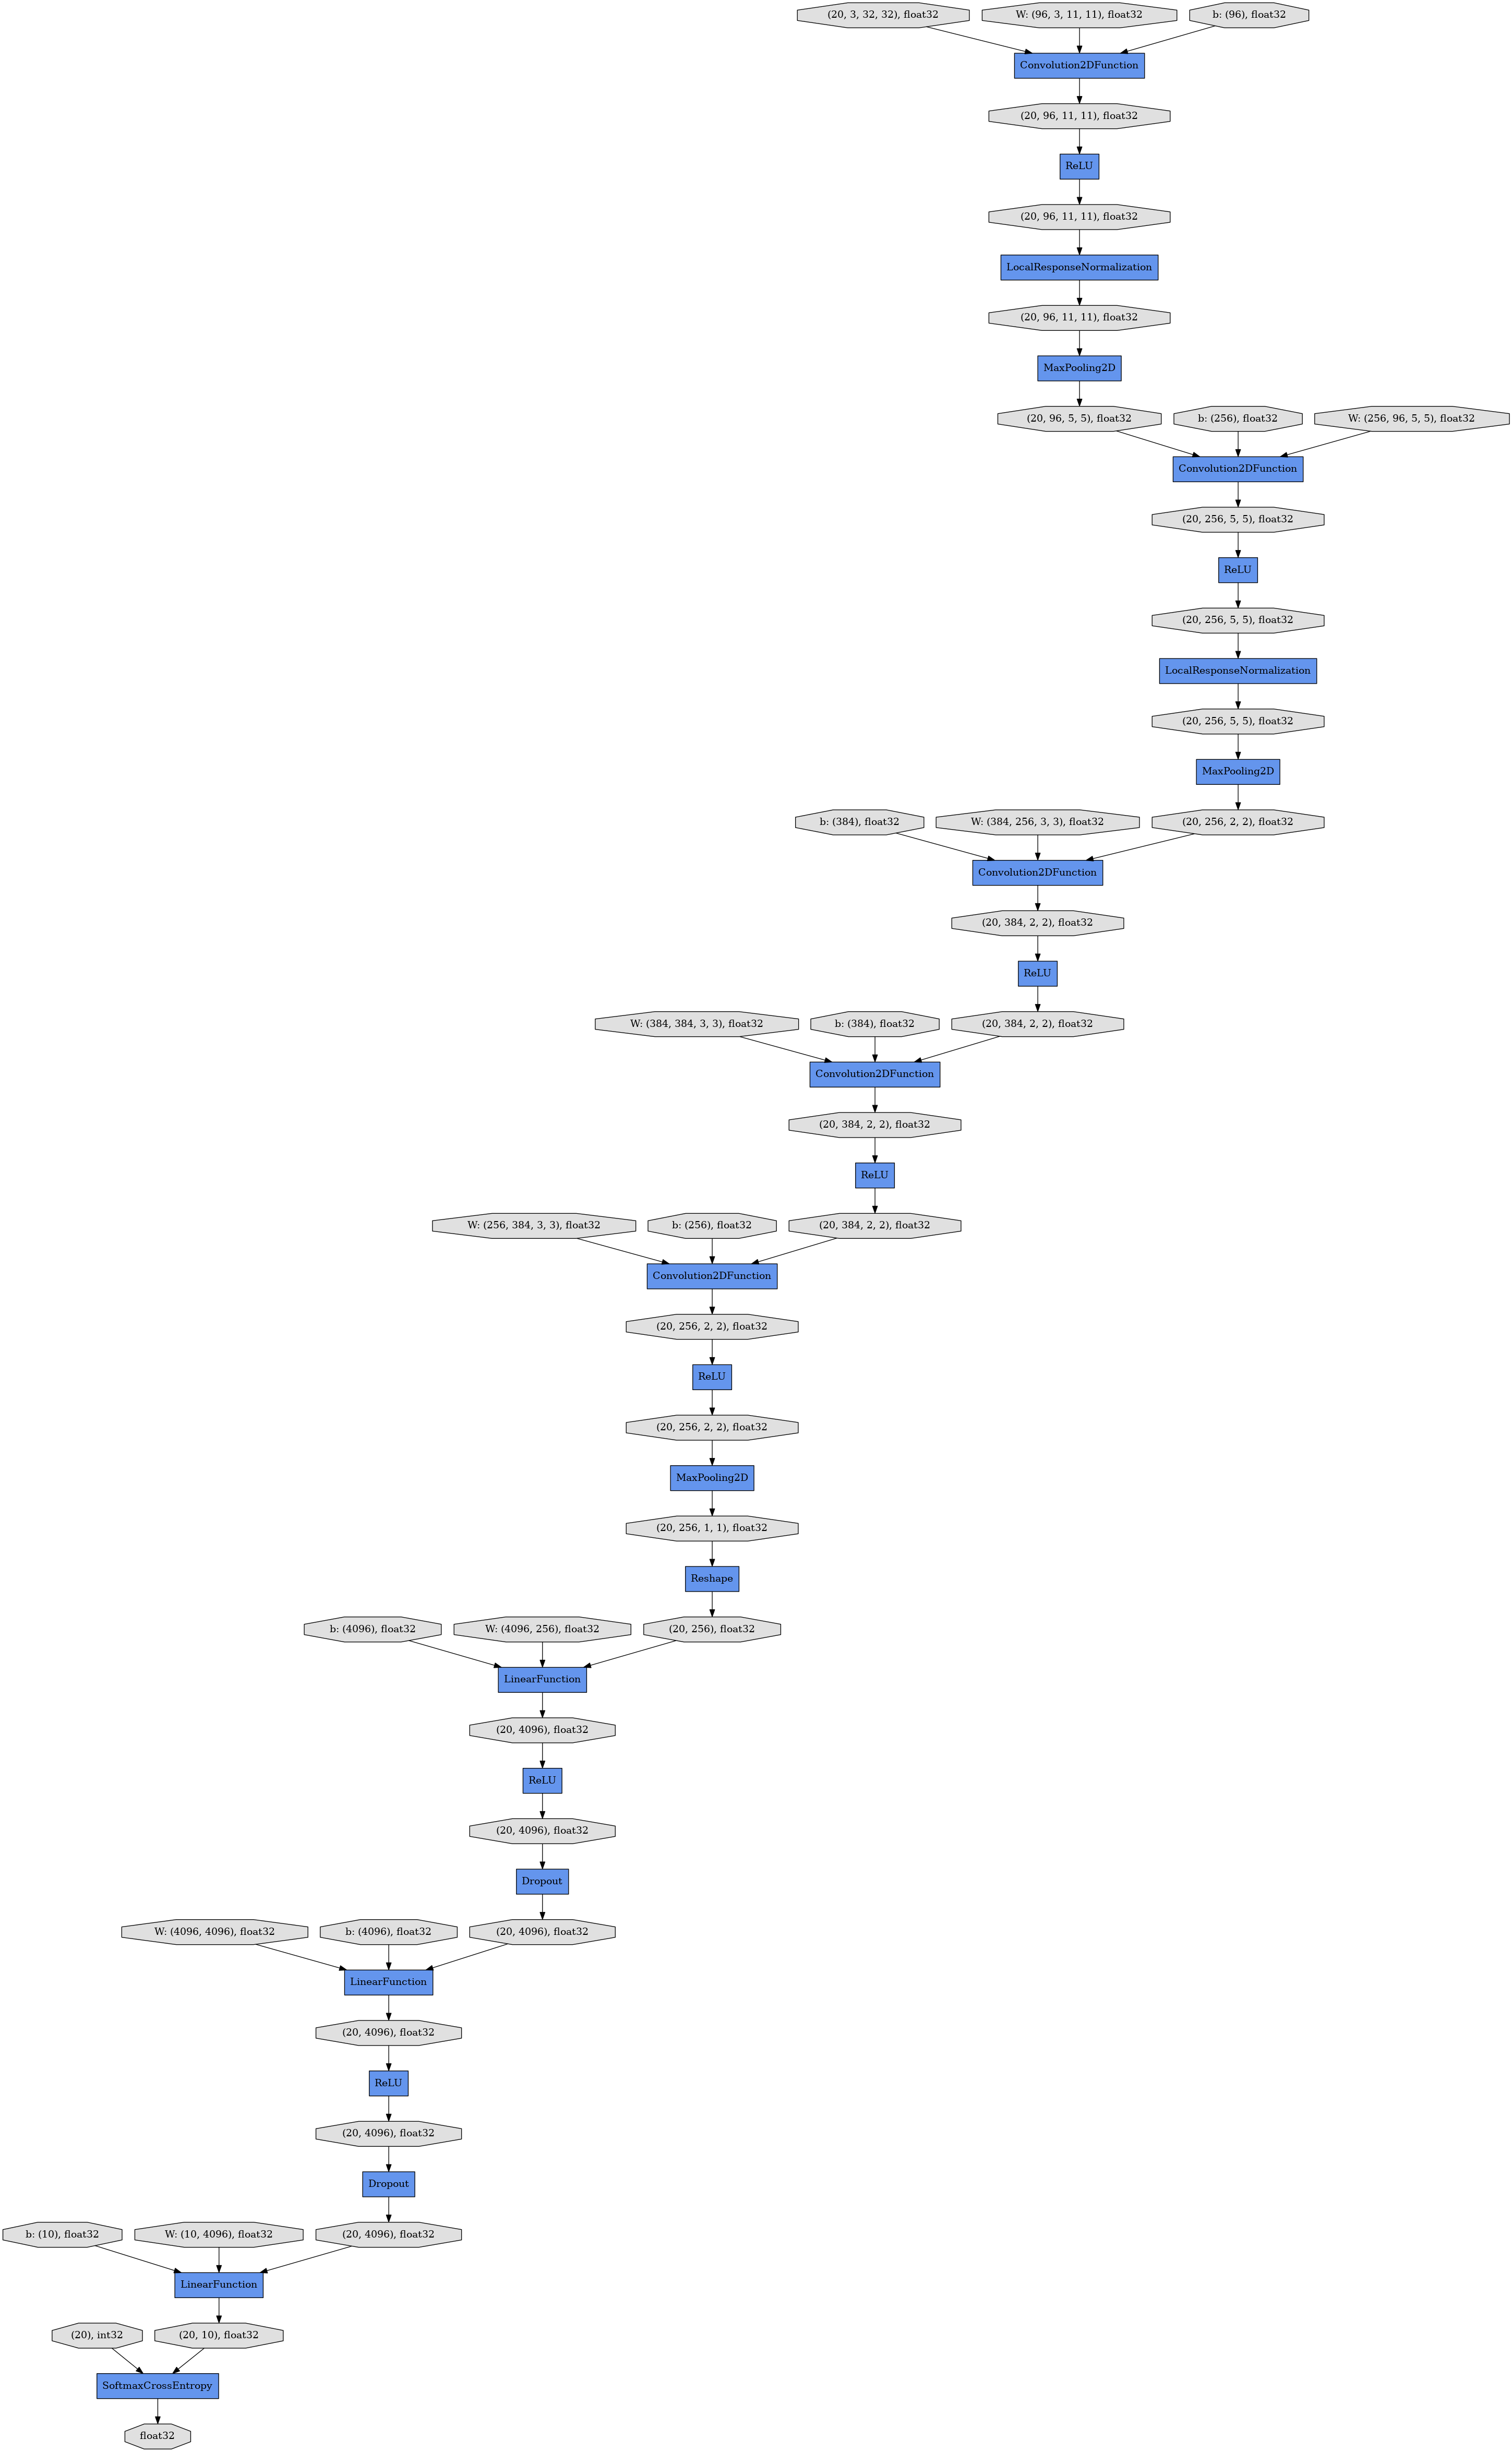

In [0]:
!dot -Tpng result/cg.dot -o result/net.png
Image('result/net.png', width=1500, height=2000)

# テスト (学習済みモデルを呼び出す)

**モデルの保存先を確認**

In [0]:
!ls result/

accuracy.png  loss.png		 model_snapshot_40  snapshot_iter_20
cg.dot	      model_snapshot_10  model_snapshot_50  snapshot_iter_30
end.model     model_snapshot_20  net.png	    snapshot_iter_40
log	      model_snapshot_30  snapshot_iter_10   snapshot_iter_50


In [0]:
chainer.config.train = False
test_model =L.Classifier(AlexNet(len(cifar10_labels), train=False))

In [0]:
serializers.load_npz("./result/end.model", test_model)

In [0]:
test_num = 10000
ok = []
no = []
pred = []
for data, test_label in test_original[0:test_num][0:test_num]:
  redata = np.reshape(data, (1, 3, 32, 32))
  x = test_model.predictor(redata)
  cls = F.argmax(x)
  pred.append(cls.data)
  if(cls.data == test_label):
    ok.append(test_label)
  else:
    no.append(test_label)
  #x = test_model.predictor(redata)

In [0]:
print('total ok data: {}'.format(len(ok)))
for number, name in enumerate(cifar10_labels):
  num = ok.count(number)
  print("{:<15} : {:>4}".format(name, num))

total ok data: 6511
airplane        :  678
automobile      :  776
bird            :  541
cat             :  459
deer            :  612
dog             :  605
frog            :  738
horse           :  621
ship            :  786
truck           :  695


In [0]:
print('total no data: {}'.format(len(no)))
for number, name in enumerate(cifar10_labels):
  num = no.count(number)
  print("{:<15} : {:>4}".format(name, num))

total no data: 3489
airplane        :  322
automobile      :  224
bird            :  459
cat             :  541
deer            :  388
dog             :  395
frog            :  262
horse           :  379
ship            :  214
truck           :  305


In [0]:
df_result = pd.DataFrame(index=[cifar10_labels], columns=['Correct', 'Incorrect', 'Total', 'Accuracy', 'Precision', 'Recall', 'F-measure'])

In [0]:
for number, name in enumerate(cifar10_labels):
  df_result['Correct'][name] = ok.count(number)
  df_result['Incorrect'][name] = no.count(number)
  df_result['Total'][name] = total = ok.count(number) + no.count(number)
  df_result['Accuracy'][name] = accuracy = ok.count(number) / total
  df_result['Precision'][name] =  precision = ok.count(number) / pred.count(number)
  df_result['Recall'][name] = recall = pred.count(number) / ok.count(number)
  df_result['F-measure'][name] = (2*recall*precision) / (recall+precision)

In [0]:

df_result

,Correct,Incorrect,Total,Accuracy,Precision,Recall,F-measure
airplane,678,322,1000,0.678,0.736,0.194,0.307
automobile,776,224,1000,0.776,0.795,0.222,0.348
bird,541,459,1000,0.541,0.554,0.155,0.242
cat,459,541,1000,0.459,0.427,0.132,0.201
deer,612,388,1000,0.612,0.548,0.175,0.266
dog,605,395,1000,0.605,0.512,0.173,0.259
frog,738,262,1000,0.738,0.731,0.212,0.328
horse,621,379,1000,0.621,0.823,0.178,0.293
ship,786,214,1000,0.786,0.747,0.225,0.346
truck,695,305,1000,0.695,0.742,0.199,0.314
